Nous allons dans ce Jupyter notebook comprendre comment le projet Dedalus fonctionne.
**à compléter à la fin**

***
# 1. Fondamentaux sur les méthodes spectrales 
***

L'idée principale d'une méthode spectrale est de changer de domaine de résolution. Au lieu de rester dans le domaine réel, on va projeter notre problème dans un espace où l'équation devient plus simple à résoudre. On réalise classiquement cela à l'aide d'une base de fonctions. 

Le coût numérique de l'algorithme est alors déplacé de "la résolution directe de l'équation différentielle" vers "le calcul du retour à l'espace réel". Cependant il existe des algorithmes très efficaces pour repasser dans l'espace réel (cf FFT). 

# Méthode spectrale classique 

La méthode spectrale est généralement présentée de la manière suivante :
1. Décomposition spectrale du problème.
2. Équation différentielle pour les coefficients spectraux.
3. Résolution des équations différentielles dans le domaine spectral.
4. Reconstruction de la solution numérique.

Dans ce contexte, nous allons nous concentrer davantage sur la représentation matricielle du problème. Bien que cela soit fondamentalement équivalent, cette approche permettra une meilleure appréhension de l'importance des bases de décomposition et de projection. Dans un second temps, cela nous aidera à mieux comprendre la méthode de Galerkin.



## Principe : décomposition et projection du problème dans une base
Considérons par exemple un problème défini par une EDP linéaire simple $Lu(x) = f(x)$, où $L$ est un opérateur différentiel par rapport à $x$.

1. On commence d'abord par écrire les fonctions du problème dans une base. On note $\{|\phi_n(x)\rangle\}_{n=1}^{\infty}$ une base orthogonale associé au produit scalaire $<|>$. La décompostion de $u$, la variable du problème, s'écrit
$$
u(x) = \sum_{n=1}^{\infty} u_n |\phi_n(x)\rangle \text{ avec }u_n = \frac{\langle u| \phi_n \rangle}{\langle \phi_n| \phi_n \rangle}.
$$ 
De même, $f$ le "terme de forçage" du probème s'écrit :
$$
f(x) = \sum_{n=1}^{\infty} f_n |\phi_n(x)\rangle \text{ avec }f_n = \frac{\langle f| \phi_n \rangle}{\langle \phi_n| \phi_n \rangle}.
$$

4. On peut alors réécrire le problème de la forme :
$$
\sum_{n=1}^{\infty} u_n L|\phi_n(x)\rangle = \sum_{n=1}^{\infty} f_n |\phi_n(x)\rangle
$$

5. On projette ensuite l'équation avec $\langle\phi_m(x)|$.
$$
\sum_{n=1}^{\infty} u_n \langle\phi_m(x)|L|\phi_n(x)\rangle = \sum_{n=1}^{\infty} f_n \langle\phi_m(x)|\phi_n(x)\rangle
$$

Nous pouvons voir que nous avons transformé notre problème d'équation différentielle en un problème matricielle. En effet, en notant :
- $D$ la matrice de dérivation défini par : $D_{ij} = \langle\phi_i(x)|L|\phi_j(x)\rangle$
- $U$ le vecteur des coefficients de $u$ dans la base : $U_{i}=u_i$
- $F$ le vecteur des coefficients de $f$ dans la base : $F_{i}=f_i$
- $B$ la matrice de la base : $B_{ij} = \langle\phi_i(x)|\phi_j(x)\rangle$
Le problème s'écrit :
$$
DU=BF
$$

Et alors le problème devient un problème d'inversion de matrice dans le but de déterminer $U=D^{-1}BF$. Un problème d'inversion de matrice est un problème très coûteux numériquement, l'objectif va être de le contourner.

**Toute l'astuce va donc être de bien choisir la base, pour rendre simple $D$ trivial à inverser. C'est-à-dire de faire en sorte que $D$ soit diagonale.**

En effet, si $D$ est diagonale alors $D^{-1}$ l'est aussi et $D^{-1}_{ii}=(D_{ii})^{-1}$.

***
**Remarque : Représentation spectrale numérique des fonctions**


Numériquement, une troncature de la décomposition est nécessaire. Pour une troncature à $N$ termes, la formule s'exprime ainsi :
$$
u(x) \approx \sum_{n=1}^{N} u_n |\phi_n(x)\rangle.
$$

La méthode spectrale serait parfaitement précise sans contrainte de troncature. L'erreur par rapport à la solution exacte, appelée **résidu**, se définit comme suit :
$$
R_N(x) = u_{\text{exacte}}(x) - u_{\text{numérique}}(x) = \sum_{n=1}^{\infty} u_n |\phi_n(x)\rangle - \sum_{n=N}^{\infty} u_n |\phi_n(x)\rangle = \sum_{n=N+1}^{\infty} u_n |\phi_n(x)\rangle
$$

- Augmenter le nombre de termes $N$ permet de minimiser le résidu.
- L'erreur de troncature est généralement de l'ordre du dernier coefficient.
- Pour des fonctions lisses, la méthode spectrale est très efficace car les coefficients décroissent de manière exponentielle.
- En revanche, elle perd en efficacité pour des fonctions non lisses (nécessitant une troncature plus importante).
- Pour les équations aux dérivées partielles (EDP) avec des solutions très différentiables, les méthodes spectrales offrent des résultats nettement plus précis par rapport aux schémas de discrétisation fixe.

***

***
**Remarque : Calcul de produit matriciel $U=D^{-1}BF$**

Un fois que l'on a calculé l'inverse de $D$, il va falloir calculer le produit matriciel : $D^{-1}BF$. 

Pour des matrices de taille $N$, ce calcul est en $O(N^2)$. Or ici, la base est orhtogonale, la matrice $B$ est donc également diagonale ! $D^{-1}$ étant diagonale, notre calcul de produt matriciel se simplifie en un simple produit :

$$
U_n = d_n^{-1}B_n f_n.
$$

Le problème passe alors de $O(N^2)$ à $O(N)$ (calcul des $N$ coefficients).
***

***
**Remarque : Notion de matrice dense et de matrice creuse/sparse**

Le problème du calcul de $D^{-1}BF$ soulève une chose : un produit matriciel est bien plus simple lorsque les matrices contiennent beaucoup de 0, on appelle ce type de matrice une **matrice creuse (sparse en anglais)** dans le cas inverse on dit que la matrice est **dense**. Un autre gros avantage est le stockage.


**Matrice Dense :**
- Une matrice dense est représentée sous forme d'un tableau à deux dimensions, où chaque élément est stocké individuellement.
- L'utilisation de mémoire est proportionnelle au nombre total d'éléments dans la matrice, même si la plupart d'entre eux sont nuls.
- Les opérations sur les matrices denses sont généralement simples mais peuvent être coûteuses en termes de calcul, surtout pour des matrices de grande taille.

**Matrice Creuse :**
- Une matrice creuse ne stocke que les éléments non nuls et leurs positions.
- Cela économise de l'espace mémoire, ce qui est particulièrement avantageux lorsque la matrice est majoritairement constituée de zéros.
- Les opérations sur les matrices creuses peuvent être plus complexes en termes de calcul en raison de la structure de stockage, mais elles sont souvent plus efficaces en termes d'utilisation de la mémoire. Des bibliothèques spécialisées telles que `scipy.sparse` en Python sont utilisées pour manipuler des matrices creuses.


Ici la matrice était diagonale, la forme la plus simple possible de matrice creuse. Elle réduit le produit maticielle en un produit simple et le stockage en un vecteur.

*Dans Dedalus, ces matrices sont toujours privilégié et les algorithmes dits "sparses" sont utilisés.*
***


## Exemple de la base de Fourrier : référence pour les problèmes périodiques

Une base très efficace pour trivialiser les dérivations dans l'opérateur $L$ est la base de Fourrier.

**Définition**

Pour un problème périodique de période $ T $, les polynômes trigonométriques (base de Fourrier) sont définies par la formule :
$$
\phi_n(x) = \frac{1}{\sqrt{T}} e^{i \frac{2\pi n x}{T}}
$$

**Produit scalaire associée**

- Le produit scalaire associé aux polynômes trigonométriques est $ \langle f, g \rangle = \int_{0}^{T} f(x) \cdot \overline{g(x)} \, dx $.

**Exemple canonique**

Considérons $L = \frac{d}{dx}$, alors 
- $B_{ij} = \langle\phi_i(x)|\phi_j(x)\rangle = \delta_{ij}$, on a bien une base orthogonale, elle est même orthonormale !
- $D_{nm} = \langle\phi_n(x)|L|\phi_m(x)\rangle = -ni\delta_{nm}$, On a une bien matrice diagonale !

La ligne de code ci-dessous permet de représenter graphiquement cet exemple.

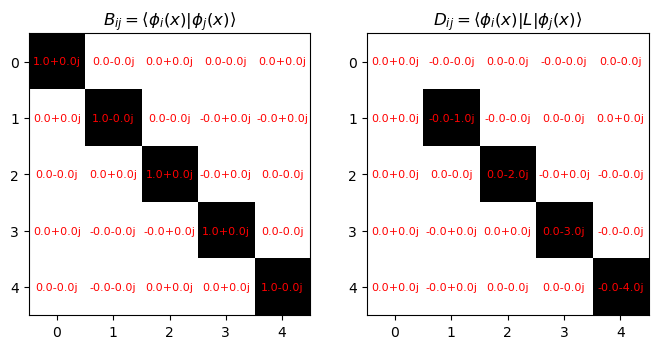

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Définition des paramètres
N = 5 #

# Définition des polynômes trigonométriques (\phi_n)
def Pn(n, x, T):
    """
    Calcule la n-ième fonction de base de Fourier pour une période T.
    
    Paramètres :
        - x : Valeurs de la variable indépendante
        - n : Indice de la fonction de base
        - T : Période de la fonction
    
    Retourne :
        - Valeurs de la n-ième fonction de base de Fourier évaluées en x
    """
    return (1/np.sqrt(T))*np.exp(1j * 2 * np.pi * n * x /T)

# Définition du produit scalaire
def inner_product(f, g, T):
    """
    Calcule le produit scalaire associé aux bases de Fourier pour une période T.
    
    Paramètres :
        - f, g : Fonctions de base de Fourier
        - T : Période de la fonction
    
    Retourne :
        - produit scalaire entre f et g
    """
    # Intégration des parties réelle et imaginaire de f et g
    integrand_real = lambda x: np.real(f(x)*np.conj(g(x)))
    integrand_imag = lambda x: np.imag(f(x)*np.conj(g(x)))

    result_real, _ = quad(integrand_real, 0, T)
    result_imag, _ = quad(integrand_imag, 0, T)

    # Résultat final
    result = result_real + 1j * result_imag
    return result


# Calcul des dérivées des polynômes trigonométriques
def dPn_dx(n, x, T):
    return (1/np.sqrt(T))*np.exp(1j * 2 * np.pi * n * x /T) * (1j * 2 * np.pi * n /T)

# Calcul des coefficents de la matrice de dérivation et de la base
D = np.zeros((N, N), dtype=np.complex128)
B = np.zeros((N, N), dtype=np.complex128)
T = 2*np.pi

for i in range(N):
    for j in range(N):
        f_Pi = lambda x: Pn(i, x, T)
        f_Pj = lambda x: Pn(j, x, T)
        f_dP = lambda x: dPn_dx(j, x, T)

        D[i, j] = inner_product(f_Pi, f_dP, T)
        B[i, j] = inner_product(f_Pi, f_Pj, T)

# Fonction pour afficher la matrice avec des carrés noires pour les valeurs > epsilon et blanc sinon
def plot_matrix(ax, matrix, title, epsilon=1e-5):
    ax.imshow(np.imag(matrix)**2 + np.real(matrix)**2 > epsilon, cmap='binary', interpolation='none')

    for i in range(N):
        for j in range(N):
            ax.text(j, i, f'{matrix[i, j]:.1f}', color='red',
                     ha='center', va='center', fontsize=8)

    ax.set_title(title)

# Création de sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(8, 8))


# Affichage des matrices
plot_matrix(axs[0], B, r'$B_{ij} = \langle\phi_i(x)|\phi_j(x)\rangle$')
plot_matrix(axs[1], D, r'$D_{ij} = \langle\phi_i(x)|L|\phi_j(x)\rangle$')

On voit donc que la base de fourrier est parfaitement adaptée pour résoudre des problèmes d'équations différentielles par la méthode spectrale.

Le calcul de l'inverse et le produit matriciel sont trivials dans cette base !

**Limites: La base de fourrier ne fonctionne que pour un problème périodique. Comment faire s'il ne l'est pas ?**

> Pour étudier des problèmes non périodiques, on va plutôt utiliser une base de polynômes. On va en particulier s'intéresser dans ce projet au polynôme de Chebysev.

## Exemples des Polynômes de Chebyshev : premier aperçu de la famille

**Définitions:**
Les polynômes de Chebyshev, notés $T_n(x)$, sont définis par la formule 
$$
T_n(x) = \cos(n \cos^{-1}(x)).
$$

**Produit scalaire associé :**
- Le produit scalaire associé aux polynômes de Chebyshev est $ \langle f, g \rangle = \int_{-1}^{1} \frac{f(x) \cdot g(x)}{\sqrt{1-x^2}} \, dx $.

**Exemple canonique**

Reprenons le même exemple que pour la base de Fourrier

Considérons $L = \frac{d}{dx}$, alors 
- $B_{ij} = \langle T_i(x)|T_j(x)\rangle = \delta_{ij}\langle T_i(x)|T_j(x)\rangle$, on a bien une base orthogonal.
- $D_{nm} = \langle T_n(x)|L|T_m(x)\rangle$, cette matrice n'est pas du tout diagonale, au contraire, elle est dense. Le problème d'inversion n'est donc pas trivial et est très coûteux numériquement.

La ligne de code ci-dessous permet de représenter graphiquement cet exemple.


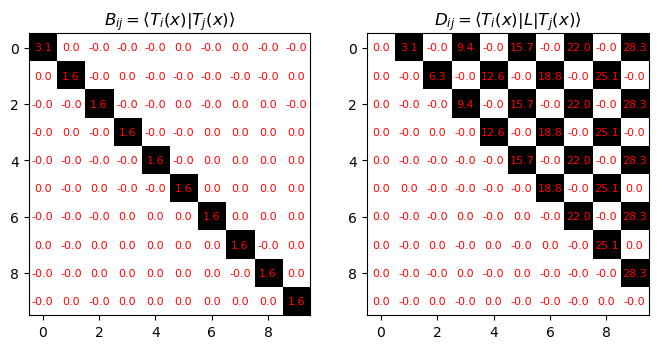

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Définition des paramètres
N = 10 #

# Définition des polynômes de Chebyshev 
def Tn(n, x):
    """
    Calcule la n-ième fonction de base des polynômes de Chebyshev 
    
    Paramètres :
        - x : Valeurs de la variable indépendante
        - n : Indice de la fonction de base
    
    Retourne :
        - Valeurs de la n-ième fonction de base des polynômes de Chebyshev  évaluées en x
    """
    return np.cos(n * np.arccos(x))

# Définition du produit scalaire
def inner_product(f, g):
    integrand = lambda x: f(x) * g(x) / np.sqrt(1 - x**2)
    result, _ = quad(integrand, -1, 1)
    return result


# Calcul des dérivées des polynômes de Chebysev 
def dTn_dx(n, x):
    return n * np.sin(n * np.arccos(x)) / np.sqrt(1 - x**2)

# Calcul des coefficents de la matrice de dérivation et de la base
D = np.zeros((N, N))
B = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        f_Ti = lambda x: Tn(i, x)
        f_Tj = lambda x: Tn(j, x)
        f_dT = lambda x: dTn_dx(j, x)

        D[i, j] = inner_product(f_Ti, f_dT)
        B[i, j] = inner_product(f_Ti, f_Tj)

# Fonction pour afficher la matrice avec des carrés noires pour les valeurs > epsilon et blanc sinon
def plot_matrix(ax, matrix, title, epsilon=1e-5):
    ax.imshow(np.abs(matrix) > epsilon, cmap='binary', interpolation='none')

    for i in range(N):
        for j in range(N):
            ax.text(j, i, f'{matrix[i, j]:.1f}', color='red',
                     ha='center', va='center', fontsize=8)

    ax.set_title(title)

# Création de sous-graphiques
fig, axs = plt.subplots(1, 2, figsize=(8, 8))


# Affichage des matrices
plot_matrix(axs[0], B, r'$B_{ij} = \langle T_i(x)| T_j(x)\rangle$')
plot_matrix(axs[1], D, r'$D_{ij} = \langle T_i(x)|L| T_j(x)\rangle$')

D'autres bases ont été essayé, mais le problème était toujours le même : la matrice de dérivation est dense.

> Une astuce très efficace pour retrouver un problème trivial est d'utiliser une méthode spectrale plus élaborée que l'on appelle méthode de Galerkin.

# Méthode de Galerkin

Le principe de cette méthode va être d'utiliser deux bases plutôt qu'une.

## Principe : décomposition la base d'essaie et projection dans la base de test
Reprenons ce que nous avons fait auparavant avec la méthode spectrale classique.

On considère le même problème défini par une EDP linéaire simple $Lu(x) = f(x)$, où $L$ est un opérateur différentiel par rapport à $x$.

1. On commence d'abord par écrire les fonctions du problème dans une première base, cette base sera appelée **base d'essai**. On la note $\{|\phi_n(x)\rangle\}_{n=1}^{\infty}$, base orthogonale associé au produit scalaire $<|>_1$. La décompostion de $u$, la variable du problème s'écrit
$$
u(x) = \sum_{n=1}^{\infty} u_n |\phi_n(x)\rangle \text{ avec }u_n = \frac{\langle u| \phi_n \rangle_1}{\langle \phi_n| \phi_n \rangle_1}.
$$ 
De même, $f$ le "terme de forçage" du probème s'écrit :
$$
f(x) = \sum_{n=1}^{\infty} f_n |\phi_n(x)\rangle \text{ avec }f_n = \frac{\langle f| \phi_n \rangle_1}{\langle \phi_n| \phi_n \rangle_1}.
$$

5. On peut alors réécrire le problème de la forme :
$$
\sum_{n=1}^{\infty} u_n L|\phi_n(x)\rangle = \sum_{n=1}^{\infty} f_n |\phi_n(x)\rangle
$$

6. On projette ensuite l'équation sur une autre base, cette base sera appelée **base de test**. On la note $\{|\psi_n(x)\rangle\}_{n=1}^{\infty}$, base orthogonale associé au produit scalaire $<|>_2$. 
$$
\sum_{n=1}^{\infty} u_n \langle\psi_m(x)|L|\phi_n(x)\rangle_2 = \sum_{n=1}^{\infty} f_n \langle\psi_m(x)|\phi_n(x)\rangle_2
$$

Nous pouvons voir que nous avons transformé notre problème d'équation différentielle en un problème matricielle. En effet, en notant :
- $D$ la matrice dérivartion défini par : $D_{ij} = \langle\psi_i(x)|L|\phi_j(x)\rangle_2$
- $U$ le vecteur des coefficients de $u$ dans la base : $U_{i}=u_i$
- $F$ le vecteur des coefficients de $f$ dans la base : $F_{i}=f_i$
- $B_1$ la matrice de la base d'essaie : $B_{1,ij} = \langle\phi_i(x)|\phi_j(x)\rangle_1$
- $B_2$ la matrice de la base de test: $B_{2,ij} = \langle\psi_i(x)|\psi_j(x)\rangle_2$
- $M$ la matrice de changement de base : $M_{ij} = \langle\psi_i(x)|\phi_j(x)\rangle_2$
Le problème s'écrit :
$$
DU=MF
$$

On retrouve le même type de problème que dans le cas de la méthode spectrale classique. En revanche, nous avons plus de liberté pour réussir à diagonaliser $D$ car nous pouvons maintenant jouer avec deux bases.

***
**Remarque : Choix de la base d'essaie et la base de test**

Par ordre de priorité, il faut choisir ces bases de manière à :
1. Rendre creuse la matrice $D$ et dans l'idéal diagonale.
2. Rendre $M$ la plus creuse possible.
 
***



### Exemples des polynômes de Chebyshev : référence pour les problèmes non périodiques 

En réalité, il existe deux sortes de polynôme de Chebyshev, ceux que nous avions étudié auparavant sont ceux de première espèce.

**Définitions:**
1. Les polynômes de Chebyshev du premier ordre, notés $T_n(x)$, sont définis par la formule 
$$
T_n(x) = \cos(n \cos^{-1}(x))
$$.
2. Les polynômes de Chebyshev du second ordre, notés $U_n(x)$, sont définis par la formule 
$$
U_n(x) = \frac{\sin((n+1) \cos^{-1}(x))}{\sin(\cos^{-1}(x))}
$$.

**Produit scalaire associé :**
- Le produit scalaire associé aux polynômes de Chebyshev du premier ordre est $ \langle f, g \rangle_1 = \int_{-1}^{1} \frac{f(x) \cdot g(x)}{\sqrt{1-x^2}} \, dx $.
- Le produit scalaire associé aux polynômes de Chebyshev du second ordre est $ \langle f, g \rangle_2 = \int_{-1}^{1} f(x) \cdot g(x) \cdot \sqrt{1-x^2} \, dx $.

**Exemple canonique**

Reprenons toujours le même exemple, en choisissant comme base d'essai les polynômes de Chebyshev de premier ordre, et comme base de test les polynômes de Chebyshev de second ordre.

Considérons $L = \frac{d}{dx}$, alors 
- $B_{1,ij} = \langle T_i(x)|T_j(x)\rangle_1 = \delta_{ij}\langle T_i(x)|T_j(x)\rangle$, on a bien une base orthogonal.
- $B_{2,ij} = \langle U_i(x)|U_j(x)\rangle_2 = \delta_{ij}\langle U_i(x)|U_j(x)\rangle$, on a bien une base orthogonal.
- $D_{nm} = \langle U_n(x)|L|T_m(x)\rangle_2$, cette matrice est bien diagonale ! 
- $M_{ij} = \langle U_i(x)|\ T_j(x)\rangle_2$, on peut montrer que cette matrice est creuse, plus précisément composé de deux diagonales (cf l'exemple numérique ci-dessous).

On voit donc que par cette méthode, on arrive également à trivialiser des problèmes non périodique. Nous l'avons fait ici avec les polynômes de Chebyshev, mais il existe d'autres bases qui fonctionnent.

La ligne de code ci-dessous permet de représenter graphiquement cet exemple.

***
**Remarque : diagonalité d'un matrice diagoanle décalée : $D_{nm}$**

Cette matrice n'est pas exactement diagonale, mais presque. c'est en fait ce qu'on appelle une matrice diagonale décalée. Son inversion reste trivial.

**Décalage (matrice de décalage vers le bas) :**
- Une matrice de décalage vers le bas, notée $D$, a des éléments définis comme $D_{ij} = \delta_{ij-1}$.
- La matrice de décalage vers le bas effectue un décalage des éléments vers le bas d'une position.

**Inverse d'une matrice de décalage vers le bas :**
- L'inverse d'une matrice de décalage vers le bas $D$ est une matrice de décalage vers le haut.
- Notation : $D^{-1}$.
- L'inverse d'une matrice de décalage vers le bas décale les éléments vers le haut d'une position.
- Chaque terme de $D^{-1}$ est donné par $(D^{-1})_{ij} = \delta_{ij+1}$.

**Matrice de décalage pondéré vers le bas :**
- Une matrice de décalage pondéré vers le bas $A$ a des éléments définis comme $A_{ij} = \delta_{ij-1} \cdot a_{ij}$, où $a_{ij}$ sont des coefficients arbitraires.
- L'inverse d'une matrice de décalage pondéré vers le bas a des éléments $(A^{-1})_{ij} = \delta_{ij+1} \cdot \frac{1}{a_{i(j+1)}}$.
- Cette matrice combine les décalages vers le bas avec une pondération par les coefficients $a_{ij}$.
***

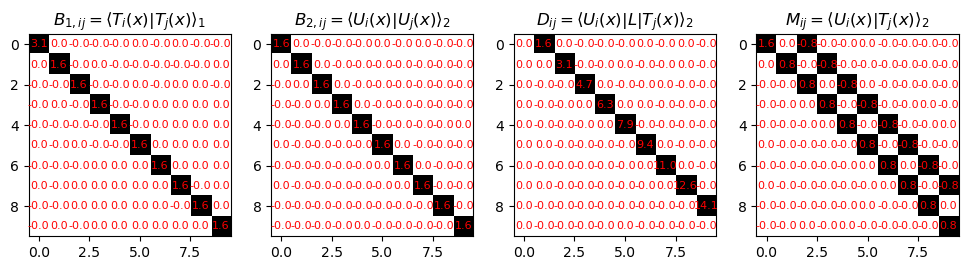

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Définition des paramètres
N = 10

# Définition des polynômes de Chebysev du premier ordre (T_n)
def Tn(n, x):
    return np.cos(n * np.arccos(x))

# Définition des polynômes de Chebysev du second ordre (U_n)
def Un(n, x):
    numerator = np.sin((n + 1) * np.arccos(x))
    denominator = np.sin(np.arccos(x))
    return numerator / denominator

# Définition des produits scalaires
def inner_product_1(f, g):
    integrand = lambda x: f(x) * g(x) / np.sqrt(1 - x**2)
    result, _ = quad(integrand, -1, 1)
    return result

def inner_product_2(f, g):
    integrand = lambda x: f(x) * g(x) * np.sqrt(1 - x**2)
    result, _ = quad(integrand, -1, 1)
    return result

# Calcul des dérivées des polynômes de Chebysev du premier ordre
def dTn_dx(n, x):
    return n * np.sin(n * np.arccos(x)) / np.sqrt(1 - x**2)

# Calcul des coefficents de la décomposition
B_1 = np.zeros((N, N))
B_2 = np.zeros((N, N))
D = np.zeros((N, N))
M = np.zeros((N, N))


for i in range(N):
    for j in range(N):
        f_Ti = lambda x: Tn(i, x)
        f_Tj = lambda x: Tn(j, x)
        f_Ui = lambda x: Un(i, x)
        f_Uj = lambda x: Un(j, x)
        f_dT = lambda x: dTn_dx(j, x)

        D[i, j] = inner_product_2(f_Ui, f_dT)
        B_1[i, j] = inner_product_1(f_Ti, f_Tj)
        B_2[i, j] = inner_product_2(f_Ui, f_Uj)
        M[i, j] = inner_product_2(f_Ui, f_Tj)

# Fonction pour afficher la matrice avec des carrés noires pour les valeurs > epsilon et blanc sinon
def plot_matrix(ax, matrix, title, epsilon=1e-5):
    ax.imshow(np.abs(matrix) > epsilon, cmap='binary', interpolation='none')

    for i in range(N):
        for j in range(N):
            ax.text(j, i, f'{matrix[i, j]:.1f}', color='red',
                     ha='center', va='center', fontsize=8)

    ax.set_title(title)

# Création de sous-graphiques
fig, axs = plt.subplots(1, 4, figsize=(12, 12))


# Affichage des matrices
plot_matrix(axs[0], B_1, r'$B_{1,ij} = \langle T_i(x)|T_j(x)\rangle_1$')
plot_matrix(axs[1], B_2, r'$B_{2,ij} = \langle U_i(x)|U_j(x)\rangle_2$')
plot_matrix(axs[2], D, r'$D_{ij} = \langle U_i(x)|L| T_j(x)\rangle_2$')
plot_matrix(axs[3], M, r'$M_{ij} = \langle U_i(x)| T_j(x)\rangle_2$')


# Prise en compte des conditions aux bords

Il existe plusieurs méthodes pour prendre en compte les conditions au bord dans les méthodes spectrales. Nous allons présenter ici deux méthodes : la méthode de "collocation" qui est une méthode très populaire et la méthode "tau" qui utilisé dans le projet Dedalus.



# La méthode de "collocation" : approximation aux points spécifiques du domaine

La méthode de "collocation" (résidus pondérés) est une méthode spectrale à part entière, se distinguant par son approche de décomposition de la solution dans une base adaptée. La particularité réside dans la définition des coefficients de cette décomposition, s'apparentant davantage à une combinaison linéaire qu'à une décomposition spectrale classique.

## Principe

En partant de l'équation initiale :
$$ Lu(x) = f(x). $$

On choisit $N$ vecteurs $\phi_n$ et on exprime $u(x)$ comme une somme pondérée de ces vecteurs :
$$ u(x) = \sum_{n=1}^{N} c_n \phi_n(x). $$

On note $m$ le nombre de conditions aux limites fixant les valeurs de $u$ à $m$ points distincts $x_i$, induisant $m$ conditions sur les coefficients $c_n$ :
$$ u(x_i) = \sum_{n=1}^{N} c_n \phi_n(x_i). $$

En choisissant ensuite $N-m$ points dans le plan $x$ pour représenter au mieux la discrétisation, on obtient $N-m$ équations supplémentaires de la forme :
$$ L\sum_{n=1}^{N} c_n \phi_n(x_i)=f(x_i). $$

Les points d'évaluation, définis par les conditions aux limites et la discrétisation, sont appelés les points de collocation. Cela conduit à un système de $N$ équations à $N$ inconnues ($c_n$), dont la résolution équivaut à inverser une matrice.

## Avantages 
- Prise en compte directe des conditions aux limites, sans contrainte sur le nombre.
- Efficace lorsque le nombre $N$ est suffisamment grand.

## Désavantages
- Inconvénient majeur : les matrices à inverser sont denses, engendrant un coût numérique élevé.
- des conditions aux limites plus élaborés demande des précautions.

*Cette méthode n'est pas utilisée dans Dedalus*


## Méthode "tau" : Résolution exacte par ajout de termes

### Principe 
Cette méthode consiste à introduire un terme polynomial $P(x)$ dans l'équation de départ, pondéré par un coefficient $\tau$ qui offre un degré de liberté pour respecter la condition aux limites. En présence de plusieurs conditions aux limites, plusieurs termes de ce type peuvent être ajoutés. L'équation modifiée prend alors la forme suivante :
$$ Lu(x) + \tau P(x) = f(x). $$

Il existe une solution particulière exacte du degré de $P$ pour cette équation. L'objectif de la méthode "tau" est de choisir $P$ de manière à ce que cette solution particulière soit une approximation de la solution de l'équation de départ $Lu(x) = f(x)$.

Cette méthode peut sembler contre-intuitive car elle modifie l'équation de départ, laissant penser que la solution obtenue ne sera pas une solution de l'équation initiale. Cependant, elle se révèle souvent très efficace et fournit généralement de bonnes approximations de la solution exacte de l'équation.

### Avantages 
- Les degrés de liberté introduits par les paramètres "tau" permettent l'implémentation des conditions aux limites.
- La solution obtenue n'est pas tronquée, éliminant ainsi les erreurs qui pourraient conduire à une instabilité du problème.

### Inconvénients 
- La détermination des termes optimaux à ajouter demeure un problème ouvert. Bien que les développeurs espèrent automatiser ce processus dans Dedalus à l'avenir, actuellement, ces termes doivent être ajoutés manuellement lors de la spécification des équations dans Dedalus v3.
- Le problème du résidu est transféré au degré du polynôme.

### Exemple 

Considérons l'équation :
$$ \frac{\partial u}{\partial x} - u = 0, \forall x \in [0, 1] $$ avec $u(0) = 1$.

La solution exacte est $u(x) = e^x$, mais nous cherchons une solution polynomiale approximative. La méthode "tau" généralisée modifie l'EDP comme suit :
$$ \frac{\partial u}{\partial x} - u + \tau P(x) = 0 $$

où $\tau$ est une **constante indéterminée et $P(x)$ est un polynôme spécifié**.

Si $P(x)$ est un polynôme de degré $N$, alors l'équation modifiée a également une solution polynomiale exacte $u_N(x)$ qui est également de degré $N$.

Par exemple, en prenant $P(x) = x^2$, l'EDP modifiée a la solution $u_2(x) = \frac{(x^2 + 2x + 2)}{2}$ avec $\tau = \frac{1}{2}$.

*Remarque* : La méthode tau classique choisit les polynômes tau comme les polynômes de Tchebychev, mais la méthode généralisée offre plus de liberté dans le choix de $P(x)$.

> La méthode tau  est utilisée dans Dedalus pour imposer les conditions aux limites. Elle est combinée à la méthode de Galerkin.


# Résumé de cette section
### Principes 
- La méthode spectrale classique consiste en la décomposition du problème sur une base adaptée.
- La méthode de Galerkin généralise ce principe en décomposant le problème sur une base dîte d'essaie, puis le problème est projeté sur une base dîte de test. L'intérêt étant d'avoir plus de jeux pour les bases, afin d' être sûre de pouvoir facilement inverser la matrice de dérivation.

### Déplacement du problème
Ces méthodes transforment un problème d'équation différentielle, en les problèmes suivants :
- Inversion de matrice -> choix de bonnes bases = trivialisation de l'inversion en $O(N)$ si matrice diagonale.
- Produit matricielle -> choix de bonnes bases = simplification entre $O(N)$ et $O(N^2)$.
- Décomposition inverse des coeffcients -> algorithme 'fast transform' = $O(N\log N)$.

### Bases fondamentales
On retiendra deux bases principales :
1. **La base de Fourier** : pour les problèmes (lisses) périodiques 
2. **Les polynôme de Chebyshev** : pour les problèmes (lisses) non périodiques

### Conditions aux limites 
Méthodes pour imposer les condtions aux limites
- La méthode de collocation
- **La méthode tau** : méthode utilisée dans *Dedalus*
